In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

2023-11-15 14:59:42.358259: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 14:59:42.398145: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 14:59:42.399536: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 14:59:43.110187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Read agricultural data into pandas df

In [2]:
#Read CSV into dataframe
ag_data = pd.read_csv('Agrofood_co2_emission.csv')

#Format column headers
ag_data.columns = ag_data.columns.str.replace(' -', '')
ag_data.columns = ag_data.columns.str.replace('(', '', regex=True)
ag_data.columns = ag_data.columns.str.replace(')', '', regex=True)
ag_data.columns = ag_data.columns.str.replace(' ', '_')
ag_data.columns = map(str.lower, ag_data.columns)


ag_data.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on-farm_energy_use,rural_population,urban_population,total_population_male,total_population_female,total_emission,average_temperature_°c
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,NaN,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,NaN,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,NaN,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,NaN,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,NaN,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


In [3]:
# ag_data.info()
ag_data.shape

(6965, 31)

### Drop Unecessary Columns:
rural population, male population, female population

In [4]:
ag_data = ag_data.drop(['total_population_female', 'total_population_male', 'rural_population'], axis=1)

In [5]:
# ag_data.info()
ag_data.shape

(6965, 28)

### Combine similar columns:

fires = savanna_fires + forest_fires + fires_in_organic_soils + fires_in_humid_tropical_forests
</br>manure_mgmt = manure_applied_to_soils + manure_left_on_pasture + manure_management
</br>food_systems = food_processing + food_packaging + food_retail + food_transport + food_houshold_consumption + agrifood_systems_waste_disposal
</br>ippu_tot = ippu + pesticides_manufacturing + fertilizers_manufacturing
</br>on_farm_energy_use = on-farm_electricity_use + on-farm_energy_use

In [6]:
ag_data['fires'] = ag_data['savanna_fires']+ag_data['forest_fires']+ag_data['fires_in_organic_soils']+ag_data['fires_in_humid_tropical_forests']
ag_data['manure_mgmt'] = ag_data['manure_applied_to_soils']+ag_data['manure_left_on_pasture']+ag_data['manure_management']
ag_data['food_systems'] = ag_data['food_processing']+ag_data['food_packaging']+ag_data['food_retail']+ag_data['food_transport']+ag_data['food_household_consumption']+ag_data['agrifood_systems_waste_disposal']
ag_data['ippu_tot'] = ag_data['ippu']+ag_data['pesticides_manufacturing']+ag_data['fertilizers_manufacturing']
ag_data['on_farm_energy_use'] = ag_data['on-farm_electricity_use'] + ag_data['on-farm_energy_use']

In [7]:
#Drop individual columns
ag_data = ag_data.drop(['savanna_fires', 'forest_fires', 'fires_in_organic_soils', 'fires_in_humid_tropical_forests',
                       'manure_applied_to_soils', 'manure_left_on_pasture', 'manure_management', 'food_processing',
                       'food_packaging', 'food_retail', 'food_transport', 'food_household_consumption',
                       'agrifood_systems_waste_disposal', 'ippu', 'pesticides_manufacturing', 'fertilizers_manufacturing',
                       'on-farm_electricity_use', 'on-farm_energy_use'], axis=1)

In [8]:
# ag_data.info()
ag_data.shape

(6965, 15)

### Read Multivariate ENSO Index (MEI) data into pandas df

In [9]:
enso_data = pd.read_csv('meiv2.csv')
enso_data.columns = map(str.lower, enso_data.columns)

#Drop years before 1990 and after 2020
enso_data = enso_data[enso_data['year'] <= 2020]
enso_data = enso_data[enso_data['year'] > 1989]

enso_data = enso_data.set_index('year')

#Calculate yearly average index
enso_data['mei'] = enso_data.mean(axis=1)

#Reset index
enso_data = enso_data.reset_index(names=['year'])

#Drop months columns
enso_data = enso_data.drop(["dj",'jf','fm','ma','am','mj','jj','ja','as','so','on','nd'], axis='columns')

### Join DFs

In [10]:
ag_data = ag_data.merge(enso_data, left_on='year', right_on='year')

In [11]:
ag_data.head()

,area,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
0,Afghanistan,1990,205.6077,686.000000,0.0000,-2388.8030,0.0000,2593947.0,2198.963539,0.536167,14.7794,2169.8513,1263.479256,233.782283,NaN,0.2
1,Albania,1990,59.2391,23.520000,110.5705,72.8581,0.0000,1195379.0,3475.291240,0.735750,12.5814,1054.6462,650.148524,1125.636617,366.090800,0.2
2,Algeria,1990,164.2776,4.312000,0.0000,-111.1403,684.9333,13496502.0,22326.596965,1.005583,144.6946,2758.8447,13250.763265,5288.278000,141.633800,0.2
3,American Samoa,1990,NaN,926.342278,0.0000,-58.8991,7.9612,38076.0,5299.122499,0.566500,0.0000,NaN,199.688951,NaN,58.504263,0.2
4,Andorra,1990,NaN,926.342278,0.0000,0.0000,0.0000,51627.0,5576.553292,1.278500,0.0000,NaN,570.011357,1711.187476,74.704263,0.2


In [12]:
# ag_data.info()
ag_data.shape

(6965, 16)

### Read Continents Data into Pandas DF

In [13]:
region_data = pd.read_csv('continents.csv')
# https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
# linked from kaggle: https://www.kaggle.com/datasets/andradaolteanu/country-mapping-iso-continent-region

In [14]:
# drop columns not needed
region_data = region_data.drop(['alpha-2', 'alpha-3', 'country-code', 'iso_3166-2','intermediate-region', 
                                'region-code', 'sub-region-code','intermediate-region-code'], axis=1)

### Merge Regions into Emissions DF

In [15]:
ag_data = ag_data.merge(region_data, left_on='area', right_on='name', how='left').drop(['name'], axis=1)

In [16]:
# manually update region & sub-region information:

def update_regions():

    asia_region = ['China, Hong Kong SAR',
                    'China, Macao SAR',
                    'China, Taiwan Province of',
                    'China, mainland',
                    "Democratic People's Republic of Korea",
                    'Republic of Korea']
    
    for area in asia_region:
        ag_data.loc[ag_data['area']==area,'region']='Asia'
        ag_data.loc[ag_data['area']==area,'sub-region']='East Asia'

    
    # 'British Virgin Islands' # Americas, Latin America and the Caribbean 
    # 'United States Virgin Islands' # Americas, Latin America and the Caribbean
    americas_region = ['British Virgin Islands', 'United States Virgin Islands']    
    
    for area in americas_region:
        ag_data.loc[ag_data['area']==area,'region']='Americas'
        ag_data.loc[ag_data['area']==area,'sub-region']='Latin America and the Caribbean'
    
    #'Palestine' # Asia, Western Asia
    ag_data.loc[ag_data['area']=='Palestine','region']='Asia'
    ag_data.loc[ag_data['area']=='Palestine','sub-region']='Western Asia'

    # 'Wallis and Futuna Islands' # Oceania, Polynesia
    ag_data.loc[ag_data['area']=='Wallis and Futuna Islands','region']='Oceania'
    ag_data.loc[ag_data['area']=='Wallis and Futuna Islands','sub-region']='Polynesia'

    # 'Republic of Moldova' # Europe, Eastern Europe
    # 'Serbia and Montenegro' # Europe, Southern Europe
    # 'Channel Islands' # Europe, Northern Europe
    # 'Netherlands (Kingdom of the)' # Europe, Western Europe
    # 'Belgium-Luxembourg' # Europe, Western Europe
    europe_region = ['Republic of Moldova',
                     'Serbia and Montenegro',
                     'Channel Islands',
                     'Netherlands (Kingdom of the)',
                     'Belgium-Luxembourg']
    for area in europe_region:
        ag_data.loc[ag_data['area']==area,'region']='Europe'
        ag_data.loc[ag_data['area']==area,'sub-region']='Wstern Europe'

    ag_data.loc[ag_data['area']=='Republic of Moldova','sub-region']='Eastern Europe'
    ag_data.loc[ag_data['area']=='Serbia and Montenegro','sub-region']='Southern Europe'
    ag_data.loc[ag_data['area']=='Channel Islands','sub-region']='Northern Europe'
    

    # 'Ethiopia PDR' # Afria, Sub-Saharan Africa
    # 'United Republic of Tanzania' # Afria, Sub-Saharan Africa
    # 'Democratic Republic of the Congo' # Africa, Sub-Saharan Africa
    africa_region = ['Ethiopia PDR', 'United Republic of Tanzania', 'Democratic Republic of the Congo']

    for area in africa_region:
        ag_data.loc[ag_data['area']==area,'region']='Africa'
        ag_data.loc[ag_data['area']==area,'sub-region']='Sub-Saharan Africa'


update_regions()

In [17]:
# areas not in region data set
ag_data[ag_data.region.isna()].groupby('area')['year'].count()

area
Czechoslovakia                      3
Netherlands Antilles (former)      21
Pacific Islands Trust Territory     1
Sudan (former)                     22
USSR                                2
Yugoslav SFR                        2
Name: year, dtype: int64

### Evaluate Countries with fewer than 31 years:

In [18]:
ag_data_area = ag_data.groupby('area').sum()
ag_data_area.loc[ag_data_area['year'] != 62155]

,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
area,,,,,,,,,,,,,,,
Armenia,58174,867.9864,7193.783413,0.000000e+00,-7.207147e+02,2917.1471,5.635726e+07,9.744722e+04,30.398333,147.4283,12704.6754,3.341263e+04,3.442255e+04,6501.743700,-2.933333
Azerbaijan,58174,4224.8868,540.850300,0.000000e+00,-6.026048e+04,4081.8835,1.347994e+08,2.730205e+05,30.718750,869.7217,57311.7177,1.505620e+05,5.691915e+04,58770.713500,-2.933333
Belarus,58174,12870.7709,26863.926076,1.237739e+06,-1.428863e+06,44432.5316,2.051809e+08,7.723587e+05,43.376000,1139.1979,118212.6124,2.316582e+05,4.285815e+05,99724.217100,-2.933333
Belgium,42210,3792.0467,15238.494610,4.233712e+03,-6.181097e+04,13283.4030,2.241269e+08,7.635175e+05,31.193667,1.7183,79432.2159,2.515535e+05,4.073839e+05,50409.423300,-4.991667
Belgium-Luxembourg,19945,1530.0201,7733.039548,2.170152e+03,-5.741164e+04,10069.1510,1.015337e+08,2.627709e+05,8.839917,1.6377,45740.5605,0.000000e+00,1.623048e+05,0.000000,2.933333
Bosnia and Herzegovina,58174,1935.6795,7215.045405,3.432881e+03,3.991576e+03,0.0000,4.783055e+07,1.499274e+05,34.322833,663.6878,22613.4146,6.318621e+04,4.474690e+04,2141.983400,-2.933333
Croatia,58174,4609.2055,16056.151542,2.582154e+02,-5.376840e+04,8217.6994,6.917302e+07,2.354761e+05,36.427000,358.3903,26695.2161,7.960718e+04,1.300727e+05,23369.795000,-2.933333
Czechia,56182,12395.6109,24001.145653,7.543190e+03,-2.141410e+05,18459.6918,2.156180e+08,5.359970e+05,38.685250,16.0832,47520.7339,3.448612e+05,2.315051e+05,63835.296700,-4.125000
Czechoslovakia,5973,2158.5798,2779.026835,1.048374e+03,-5.914724e+04,2036.8200,3.234779e+07,3.579869e+04,2.250750,2.8005,14987.4518,2.195435e+04,3.603314e+04,13301.816100,2.066667


### Drop Belgium-Luxembourg

Not sure why Belgium & Luxembourg are reported together between 1990 and 2000, but not sure how to accurately split info for these years into each country. Propose dropping these data points. 

In [19]:
# ag_data[ag_data['area'] == 'Belgium']
# ag_data[ag_data['area'] == 'Luxembourg']
# ag_data[ag_data['area'] == 'Belgium-Luxembourg']

ag_data = ag_data[ag_data['area'] != 'Belgium-Luxembourg']

### Drop Czechoslovakia

Czeochoslovakia split into Czechia (Czech Republic) & Slovakia in 1993. Czechoslavakia data between 1990-1992 represents the entire region. Only lose 3 years of data. 

In [20]:
# ag_data[ag_data['area'] == 'Czechia']
# ag_data[ag_data['area'] == 'Czechoslovakia']
# ag_data[ag_data['area'] == 'Slovakia']

ag_data = ag_data[ag_data['area'] != 'Czechoslovakia']

### Drop USSR

Soviet Union fell in 1991. Drop 1990-1991. 

In [21]:
# ag_data[ag_data['area'] == 'USSR']
    
ag_data = ag_data[ag_data['area'] != 'USSR']

### Drop Yugoslavia SFR

SFRY ended in 1991

In [22]:
# ag_data[ag_data['area'] == 'Yugoslav SFR']

ag_data = ag_data[ag_data['area'] != 'Yugoslav SFR']

### Drop Pacific Islands Trust Territory

Split into Micronesia, Marshall Islands, and Palau. Only drop 1990.

In [23]:
# ag_data[ag_data['area'] == 'Pacific Islands Trust Territory']

ag_data = ag_data[ag_data['area'] != 'Pacific Islands Trust Territory']

### Rename Ethiopia PDR to Ethiopia

In [24]:
#ag_data[ag_data['area'] == 'Ethiopia PDR']
#ag_data[ag_data['area'] == 'Ethiopia']

ag_data.loc[ag_data["area"] == "Ethiopia PDR", 'area'] = "Ethiopia"

### Drop Serbia, Montenegro, Serbia & Montenegro

These countries were in a union until 2006. Very difficult to split or interpret this data. Not enough data left if we remove Serbia & Montenegro data points. Propose removing all 3 from datasest. 

In [25]:
ag_data = ag_data[ag_data['area'] != 'Serbia']
ag_data = ag_data[ag_data['area'] != 'Montenegro']
ag_data = ag_data[ag_data['area'] != 'Serbia and Montenegro']

### Drop Sudan(former), Sudan, and South Sudan

Split into two countries in 2011. Very difficult to split or interpret data prior to split. Propose removing all 3 from dataset. 

In [26]:
ag_data = ag_data[ag_data['area'] != 'Sudan (former)']
ag_data = ag_data[ag_data['area'] != 'Sudan']
ag_data = ag_data[ag_data['area'] != 'South Sudan']

### Drop Netherlands Antiles

Was a country made up of dutch colonized islands. Dissolved in 2010. Not sufficient data to keep. Propose removing. 

In [27]:
ag_data = ag_data[ag_data['area'] != 'Netherlands Antilles (former)']

### Confirm no areas are missing region data

In [28]:
# areas not in region data set
ag_data[ag_data.region.isna()].groupby('area')['year'].count()

Series([], Name: year, dtype: int64)

In [29]:
ag_data.shape

(6842, 18)

In [30]:
ag_data['area'].nunique()

223

### Find missing values by year

In [31]:

#define an array with the unique year values
years_count_missing = dict.fromkeys(ag_data['year'].unique(), 0)
for ind, row in ag_data.iterrows():
    years_count_missing[row['year']] += row.isnull().sum()

# sort the years by missing values
years_missing_sorted = dict(sorted(years_count_missing.items(), key=lambda item: item[1]))

# print the missing values for each year
print("missing values by year:")
for key, val in years_missing_sorted.items():
    print(key, ":", val)

missing values by year:
1990 : 172
2002 : 177
2003 : 177
2004 : 177
2006 : 177
2007 : 177
2008 : 177
2009 : 177
2010 : 177
2011 : 177
2012 : 177
2013 : 177
2014 : 177
2005 : 178
2015 : 178
2016 : 178
2017 : 178
2018 : 178
2019 : 178
1999 : 179
2000 : 179
2001 : 179
1995 : 180
1996 : 180
1997 : 180
1998 : 180
1994 : 181
2020 : 181
1992 : 185
1993 : 185
1991 : 191


### Find missing values by country

In [32]:
# define an array with the unique country values
areas_count_missing = dict.fromkeys(ag_data['area'].unique(), 0)

# iterate through all rows and count the amount of NaN values for each country
for ind, row in ag_data.iterrows():
    areas_count_missing[row['area']] += row.isnull().sum()

# sort the countries by missing values
areas_missing_sorted = dict(sorted(areas_count_missing.items(), key=lambda item: item[1]))

# print the missing values for each country
print("missing values by area:")
for key, val in areas_missing_sorted.items():
    print(key, ":", val)

missing values by area:
Albania : 0
Algeria : 0
Angola : 0
Argentina : 0
Australia : 0
Austria : 0
Bahamas : 0
Bangladesh : 0
Barbados : 0
Belize : 0
Benin : 0
Bhutan : 0
Bolivia (Plurinational State of) : 0
Botswana : 0
Brazil : 0
Brunei Darussalam : 0
Bulgaria : 0
Burundi : 0
Cabo Verde : 0
Cambodia : 0
Canada : 0
Central African Republic : 0
Chad : 0
Chile : 0
China : 0
China, mainland : 0
Colombia : 0
Comoros : 0
Congo : 0
Costa Rica : 0
Cuba : 0
Cyprus : 0
Democratic People's Republic of Korea : 0
Denmark : 0
Djibouti : 0
Dominica : 0
Dominican Republic : 0
Ecuador : 0
Egypt : 0
El Salvador : 0
Eswatini : 0
Finland : 0
France : 0
Gabon : 0
Ghana : 0
Greece : 0
Grenada : 0
Guatemala : 0
Guinea : 0
Guinea-Bissau : 0
Guyana : 0
Haiti : 0
Honduras : 0
Hungary : 0
Iceland : 0
India : 0
Indonesia : 0
Iran (Islamic Republic of) : 0
Ireland : 0
Israel : 0
Italy : 0
Jamaica : 0
Japan : 0
Jordan : 0
Kenya : 0
Lao People's Democratic Republic : 0
Lebanon : 0
Malawi : 0
Malaysia : 0
Mali : 0


### Drop Countries with more than 10% missing values

Data points per country: 558
</br>10%: 56

In [33]:
areas_missing_10 = dict((k, v) for k, v in areas_missing_sorted.items() if v >= 56)

In [34]:
areas_missing_10_list = list(areas_missing_10.keys())

In [35]:
areas_missing_10_list

['North Macedonia',
 'Andorra',
 'Antigua and Barbuda',
 'Aruba',
 'China, Taiwan Province of',
 'Cook Islands',
 'Puerto Rico',
 'Singapore',
 'Turks and Caicos Islands',
 'Vanuatu',
 'Marshall Islands',
 'Guadeloupe',
 'Saint Kitts and Nevis',
 'Northern Mariana Islands',
 'American Samoa',
 'Cayman Islands',
 'China, Macao SAR',
 'Gibraltar',
 'Greenland',
 'Kiribati',
 'Liechtenstein',
 'Mayotte',
 'Saint Helena, Ascension and Tristan da Cunha',
 'United Arab Emirates',
 'Martinique',
 'Falkland Islands (Malvinas)',
 'Montserrat',
 'Palestine',
 'Palau',
 'China, Hong Kong SAR',
 'Anguilla',
 'Holy See',
 'Monaco',
 'Saint Pierre and Miquelon',
 'San Marino',
 'Tokelau',
 'Wallis and Futuna Islands',
 'Bermuda',
 'Guam',
 'Western Sahara',
 'British Virgin Islands',
 'United States Virgin Islands',
 'Isle of Man',
 'Channel Islands']

In [36]:
len(areas_missing_10_list)

44

In [37]:
for area in areas_missing_10_list:
    ag_data = ag_data[ag_data.area != area]

In [38]:
ag_data.shape

(5483, 18)

In [39]:
# define an array with the unique country values
areas_count_missing = dict.fromkeys(ag_data['area'].unique(), 0)

# iterate through all rows and count the amount of NaN values for each country
for ind, row in ag_data.iterrows():
    areas_count_missing[row['area']] += row.isnull().sum()

# sort the countries by missing values
areas_missing_sorted = dict(sorted(areas_count_missing.items(), key=lambda item: item[1]))

# print the missing values for each country
print("missing values by area:")
for key, val in areas_missing_sorted.items():
    print(key, ":", val)

missing values by area:
Albania : 0
Algeria : 0
Angola : 0
Argentina : 0
Australia : 0
Austria : 0
Bahamas : 0
Bangladesh : 0
Barbados : 0
Belize : 0
Benin : 0
Bhutan : 0
Bolivia (Plurinational State of) : 0
Botswana : 0
Brazil : 0
Brunei Darussalam : 0
Bulgaria : 0
Burundi : 0
Cabo Verde : 0
Cambodia : 0
Canada : 0
Central African Republic : 0
Chad : 0
Chile : 0
China : 0
China, mainland : 0
Colombia : 0
Comoros : 0
Congo : 0
Costa Rica : 0
Cuba : 0
Cyprus : 0
Democratic People's Republic of Korea : 0
Denmark : 0
Djibouti : 0
Dominica : 0
Dominican Republic : 0
Ecuador : 0
Egypt : 0
El Salvador : 0
Eswatini : 0
Finland : 0
France : 0
Gabon : 0
Ghana : 0
Greece : 0
Grenada : 0
Guatemala : 0
Guinea : 0
Guinea-Bissau : 0
Guyana : 0
Haiti : 0
Honduras : 0
Hungary : 0
Iceland : 0
India : 0
Indonesia : 0
Iran (Islamic Republic of) : 0
Ireland : 0
Israel : 0
Italy : 0
Jamaica : 0
Japan : 0
Jordan : 0
Kenya : 0
Lao People's Democratic Republic : 0
Lebanon : 0
Malawi : 0
Malaysia : 0
Mali : 0


In [40]:

#define an array with the unique year values
years_count_missing = dict.fromkeys(ag_data['year'].unique(), 0)
for ind, row in ag_data.iterrows():
    years_count_missing[row['year']] += row.isnull().sum()

# sort the years by missing values
years_missing_sorted = dict(sorted(years_count_missing.items(), key=lambda item: item[1]))

# print the missing values for each year
print("missing values by year:")
for key, val in years_missing_sorted.items():
    print(key, ":", val)

missing values by year:
2002 : 32
2003 : 32
2004 : 32
2006 : 32
2007 : 32
2008 : 32
2009 : 32
2010 : 32
2011 : 32
2012 : 32
2013 : 32
2014 : 32
2015 : 32
2016 : 32
2017 : 32
2018 : 32
2019 : 32
1995 : 33
1996 : 33
1997 : 33
1998 : 33
1999 : 33
2000 : 33
2001 : 33
2005 : 33
2020 : 33
1994 : 34
1992 : 35
1993 : 36
1991 : 37
1990 : 38


### Impute Null Values

Compute average emissions for all columns, group by year and sub-region
</br>Replace null values with average value for that year and sub-region

In [41]:
ag_data.isnull().sum()

area                           0
year                           0
crop_residues                250
rice_cultivation               0
drained_organic_soils_co2      0
forestland                     0
net_forest_conversion          0
urban_population               0
total_emission                 0
average_temperature_°c         0
fires                          0
manure_mgmt                   35
food_systems                 100
ippu_tot                      93
on_farm_energy_use           543
mei                            0
region                         0
sub-region                     0
dtype: int64

In [42]:
ag_data[ag_data['crop_residues'].isnull()].groupby('area').sum()

,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
area,,,,,,,,,,,,,,,
Bahrain,4025,0.0,1515.513286,0.0000,-5.1600,0.0000,2305816.0,14630.473086,3.334500,0.0000,66.1694,5475.665800,7499.039600,0.000000,-0.683333
Equatorial Guinea,62155,0.0,25615.721335,1.3162,-63030.9163,181798.1238,15478753.0,231010.733962,22.450683,13.4529,281.9080,14110.303996,70548.273031,1672.551000,-2.058333
Nauru,62155,0.0,29379.607125,0.0000,0.0000,0.0000,318582.0,65103.097417,16.492636,0.0000,41.8846,8451.234184,27039.328008,191.043500,-2.058333
Niue,62155,0.0,62174.634696,0.0000,-23.2440,39.3963,20465.0,100404.048472,20.647394,0.0000,34.3373,10631.128696,27018.770734,529.024746,-2.058333
Saint Lucia,62155,0.0,37066.621272,0.0000,-4429.9344,237.7080,1169200.0,73289.828260,20.849333,0.0000,369.1003,13724.700527,25645.574687,676.057874,-2.058333
Samoa,62155,0.0,29559.167069,0.0000,75.8550,3248.8731,1147804.0,119726.040820,23.582367,44.3604,3315.3891,9480.821227,73366.014578,635.560346,-2.058333
Seychelles,62155,0.0,28571.587377,0.0000,0.0000,0.0000,1397431.0,60616.383420,21.607917,0.0000,156.1155,6753.021732,24236.774564,898.884246,-2.058333
Tonga,62155,0.0,28571.587377,0.0000,0.0000,0.0000,726714.0,76646.317690,19.040250,0.0000,1577.9257,9383.423216,36835.521197,277.860200,-2.058333
Tuvalu,62155,0.0,61953.361846,0.0000,-6.4468,0.0000,161584.0,98379.114254,18.685212,0.0000,198.6784,8673.910527,27020.976234,538.634046,-2.058333


In [43]:
#Replace null values with calculated sub-region averages by year

def impute_null(df):
    cols = df.columns.tolist()
    for col in cols:
        null_indeces = df[df[col].isnull()].index.tolist()
        for index in null_indeces:
            year = df['year'][index]
            sub_region = df['sub-region'][index]
            new_value = df[(df['year']==year) & (df['sub-region']==sub_region)][col].aggregate('mean')
            df[col][index] = new_value
    return df

In [44]:
ag_data = impute_null(ag_data)

### Confirm if any additional nulls after imputing

Nauru still has null value for crop_residues in 1990 because it is the only remaining country in the Micronesia sub-region. 
Chnage this one value to zero. 

In [45]:
ag_data.isnull().sum()

area                         0
year                         0
crop_residues                1
rice_cultivation             0
drained_organic_soils_co2    0
forestland                   0
net_forest_conversion        0
urban_population             0
total_emission               0
average_temperature_°c       0
fires                        0
manure_mgmt                  0
food_systems                 0
ippu_tot                     0
on_farm_energy_use           0
mei                          0
region                       0
sub-region                   0
dtype: int64

In [46]:
ag_data.shape

(5483, 18)

In [47]:
ag_data[ag_data['crop_residues'].isnull()].groupby('area').sum()

,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
area,,,,,,,,,,,,,,,
Nauru,1990,0.0,921.664109,0.0,0.0,0.0,9155.0,2282.058615,-0.18075,0.0,1.179,474.942226,872.41178,11.8615,0.2


In [48]:
#Nauru is the only sub-region of Micronesia
ag_data[(ag_data['sub-region']== 'Micronesia') & (ag_data['year']==1990)]

,area,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei,region,sub-region
126,Nauru,1990,NaN,921.664109,0.0,0.0,0.0,9155.0,2282.058615,-0.18075,0.0,1.179,474.942226,872.41178,11.8615,0.2,Oceania,Micronesia


In [49]:
ag_data = ag_data.fillna(0)

In [50]:
ag_data.isnull().sum()

area                         0
year                         0
crop_residues                0
rice_cultivation             0
drained_organic_soils_co2    0
forestland                   0
net_forest_conversion        0
urban_population             0
total_emission               0
average_temperature_°c       0
fires                        0
manure_mgmt                  0
food_systems                 0
ippu_tot                     0
on_farm_energy_use           0
mei                          0
region                       0
sub-region                   0
dtype: int64

### Visualize Distribution of Vars

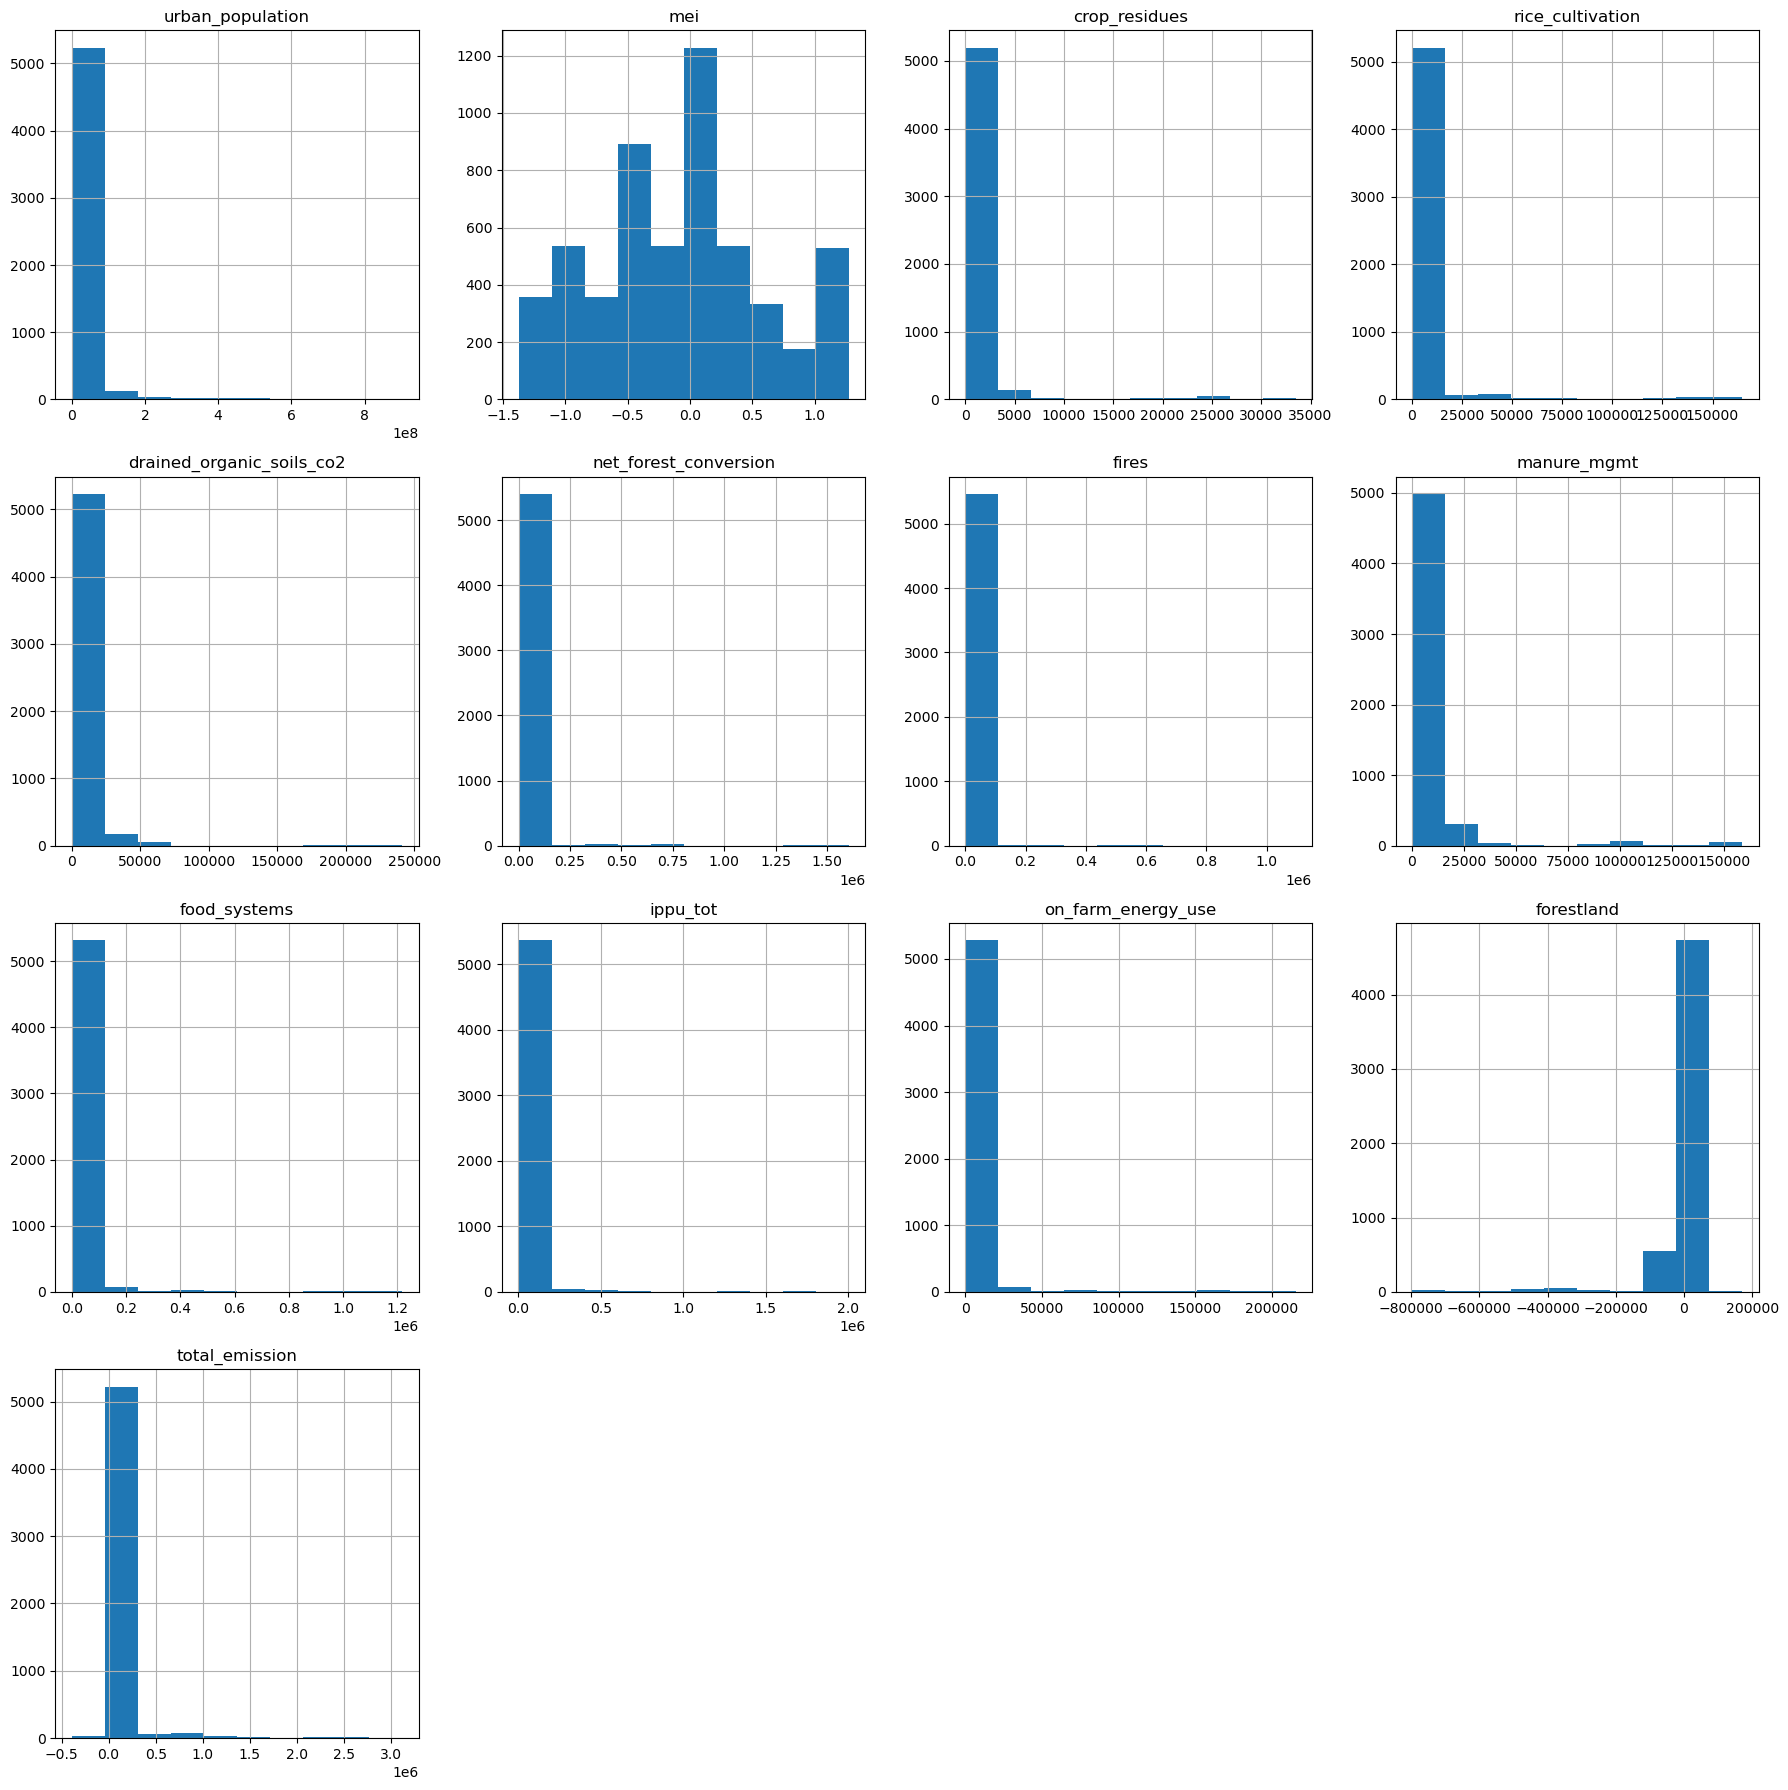

In [51]:
vars = [
 'urban_population',
 'mei',
 'crop_residues',
 'rice_cultivation',
 'drained_organic_soils_co2',
 'net_forest_conversion',
 'fires',
 'manure_mgmt',
 'food_systems',
 'ippu_tot',
 'on_farm_energy_use',
 'forestland',
 'total_emission']

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,18))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(ag_data, vars, 4,4)

### Add Log Transforms of non-normally distributed variables

In [52]:
log_vars = [
 'urban_population',
 'crop_residues',
 'rice_cultivation',
 'drained_organic_soils_co2',
 'net_forest_conversion',
 'fires',
 'manure_mgmt',
 'food_systems',
 'ippu_tot',
 'on_farm_energy_use']

for col in log_vars:
    ag_data['log_'+col] = np.log(ag_data[col]+1)

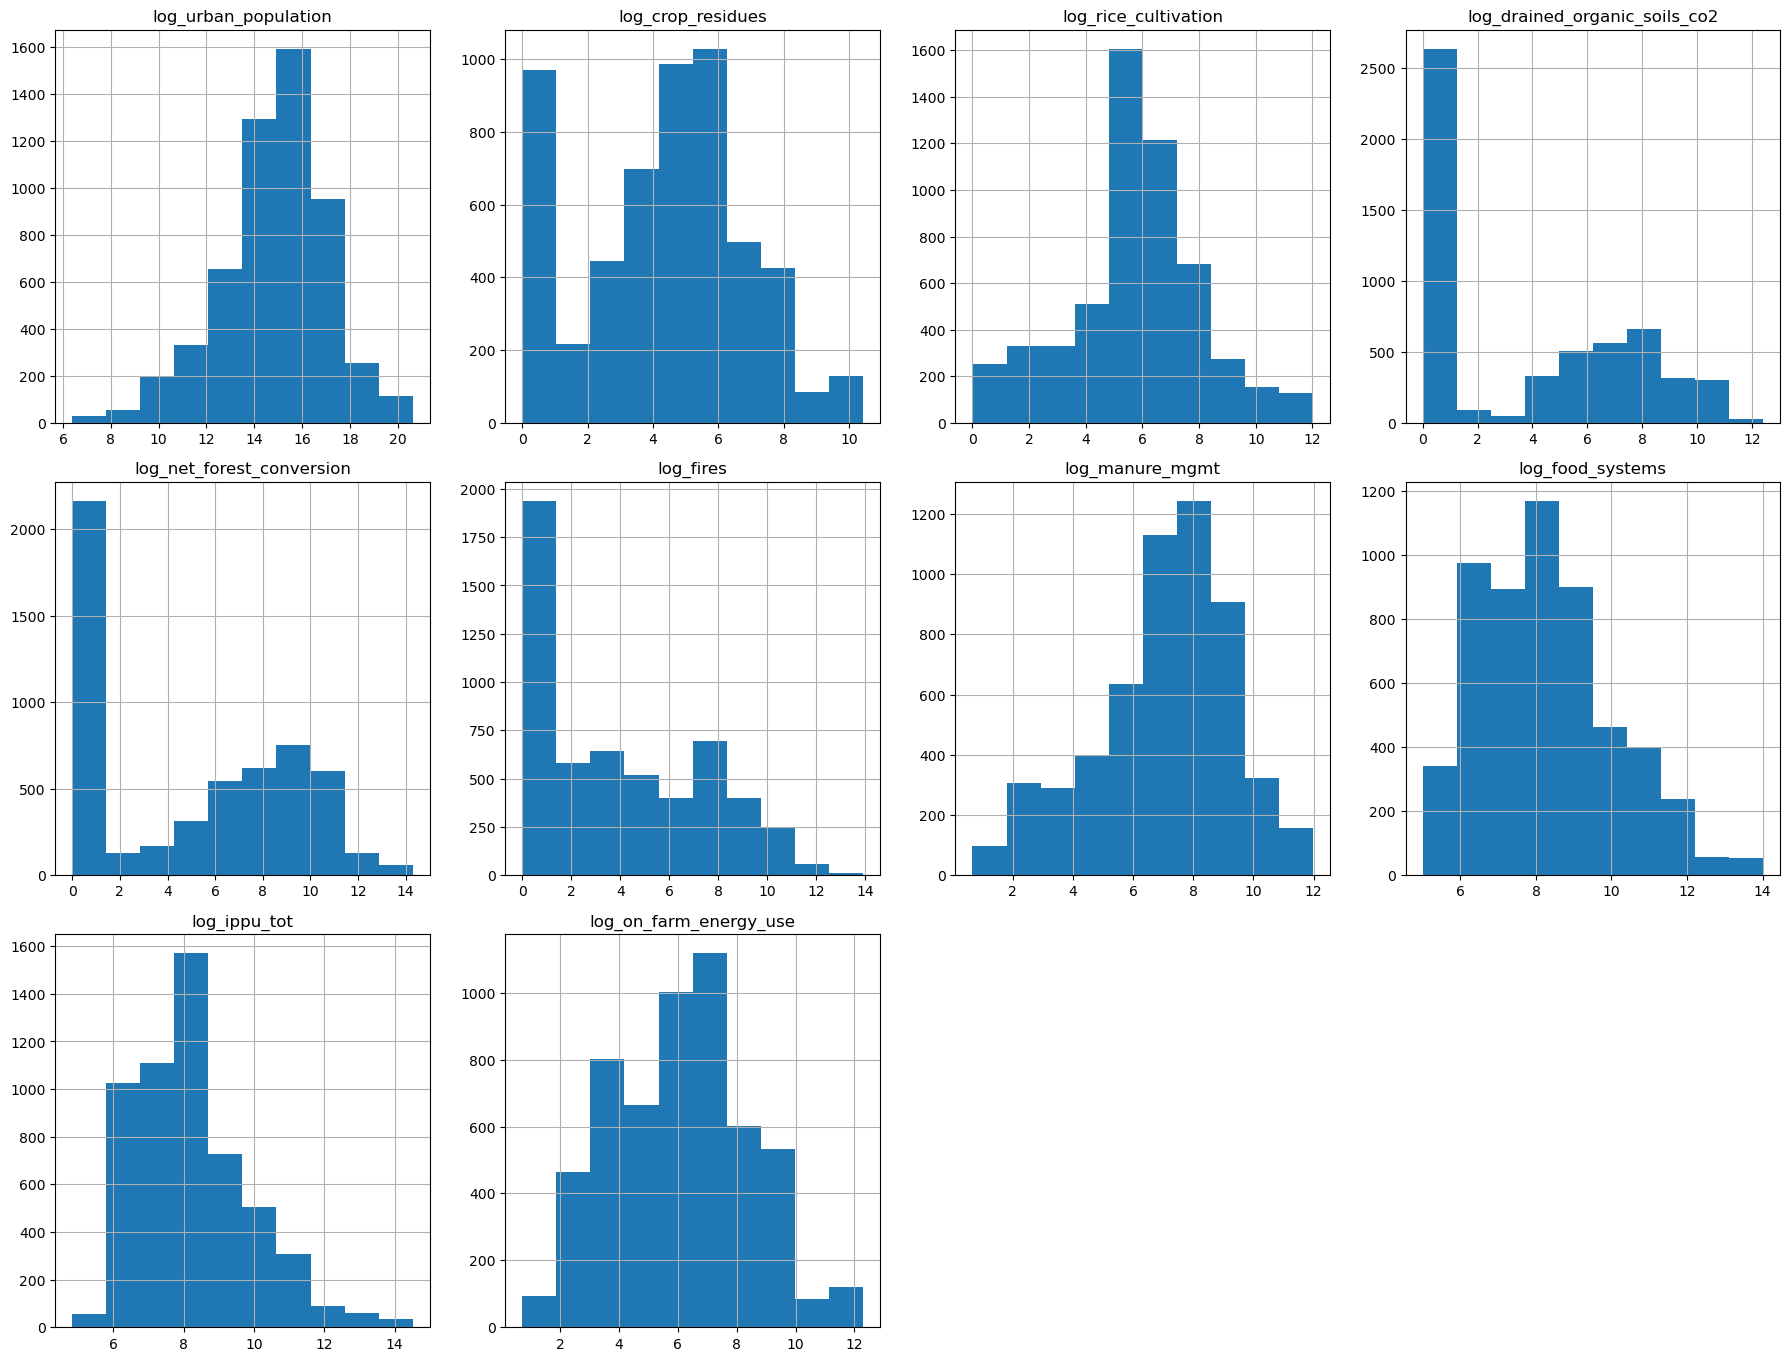

In [53]:
log_vars = [
 'log_urban_population',
 'log_crop_residues',
 'log_rice_cultivation',
 'log_drained_organic_soils_co2',
 'log_net_forest_conversion',
 'log_fires',
 'log_manure_mgmt',
 'log_food_systems',
 'log_ippu_tot',
 'log_on_farm_energy_use']

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,18))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(ag_data, log_vars, 4,4)

### Compute rolling totals & Add new columns

In [54]:
def calc_rolling_total(df, column, time_period):
    return (df
            .groupby('area')[column]
            .transform(lambda df: df.rolling(time_period).sum()))

In [55]:
cols = [ 'log_crop_residues',
 'log_rice_cultivation',
 'log_drained_organic_soils_co2',
 'log_net_forest_conversion',
 'log_fires',
 'log_manure_mgmt',
 'log_food_systems',
 'log_ippu_tot',
 'log_on_farm_energy_use', 'forestland', 'total_emission']



In [56]:
for col in cols:
    ag_data['5yr_'+str(col)] = calc_rolling_total(ag_data, col, 5)

In [57]:
for col in cols:
    ag_data['10yr_'+str(col)] = calc_rolling_total(ag_data, col, 10)

In [58]:
for col in cols:
    ag_data['20yr_'+str(col)] = calc_rolling_total(ag_data, col, 20)

In [59]:
ag_data.tail()

,area,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,...,20yr_log_rice_cultivation,20yr_log_drained_organic_soils_co2,20yr_log_net_forest_conversion,20yr_log_fires,20yr_log_manure_mgmt,20yr_log_food_systems,20yr_log_ippu_tot,20yr_log_on_farm_energy_use,20yr_forestland,20yr_total_emission
6958,Venezuela (Bolivarian Republic of),2020,110.5478,863.428600,1632.0410,957.7691,39891.3821,29284219.0,87274.841203,1.291833,...,142.834961,141.428858,224.139695,155.074541,181.589272,194.727629,194.019487,138.332174,30270.5695,2.565810e+06
6959,Viet Nam,2020,2604.8452,35694.056800,3832.8949,-17342.2622,0.0000,36727248.0,171383.629100,1.428083,...,210.499988,165.609807,40.705494,145.463014,186.076672,204.792839,203.025630,159.858735,-113923.9930,2.336352e+06
6962,Yemen,2020,42.7411,796.196122,0.0000,0.0000,0.0000,11465414.0,16313.168415,1.320126,...,130.623976,0.000000,0.000000,0.182233,158.536418,177.327368,153.171754,147.551011,0.0000,2.949848e+05
6963,Zambia,2020,205.7266,48.521800,14566.6658,0.0000,19047.2568,8336381.0,95970.904147,0.714417,...,73.473761,191.665794,180.499632,218.159446,151.142908,154.445054,144.638108,87.940656,0.0000,1.740837e+06
6964,Zimbabwe,2020,108.3022,7.973300,0.0000,76500.2982,10662.4408,5700460.0,96505.221853,0.189000,...,29.523106,0.000000,185.509734,152.034504,160.989144,152.011518,153.573349,147.113034,388368.0030,8.314149e+05


### Reorder Columns

In [60]:
reordered_cols = ['area', 'region', 'sub-region', 'year', 'urban_population', 'mei', 'crop_residues',
                  'rice_cultivation', 'drained_organic_soils_co2','net_forest_conversion', 'fires', 
                  'manure_mgmt', 'food_systems','ippu_tot', 'on_farm_energy_use', 'forestland', 
                  'total_emission', 'log_urban_population', 'log_crop_residues', 'log_rice_cultivation',
                  'log_drained_organic_soils_co2','log_net_forest_conversion','log_fires','log_manure_mgmt',
                  'log_food_systems','log_ippu_tot','log_on_farm_energy_use',
                   '5yr_log_crop_residues',
 '5yr_log_rice_cultivation',
 '5yr_log_drained_organic_soils_co2',
 '5yr_log_net_forest_conversion',
 '5yr_log_fires',
 '5yr_log_manure_mgmt',
 '5yr_log_food_systems',
 '5yr_log_ippu_tot',
 '5yr_log_on_farm_energy_use',
 '5yr_forestland',
 '5yr_total_emission',
 '10yr_log_crop_residues',
 '10yr_log_rice_cultivation',
 '10yr_log_drained_organic_soils_co2',
 '10yr_log_net_forest_conversion',
 '10yr_log_fires',
 '10yr_log_manure_mgmt',
 '10yr_log_food_systems',
 '10yr_log_ippu_tot',
 '10yr_log_on_farm_energy_use',
 '10yr_forestland',
 '10yr_total_emission',
 '20yr_log_crop_residues',
 '20yr_log_rice_cultivation',
 '20yr_log_drained_organic_soils_co2',
 '20yr_log_net_forest_conversion',
 '20yr_log_fires',
 '20yr_log_manure_mgmt',
 '20yr_log_food_systems',
 '20yr_log_ippu_tot',
 '20yr_log_on_farm_energy_use',
 '20yr_forestland',
 '20yr_total_emission','average_temperature_°c']

ag_data = ag_data[reordered_cols]

ag_data.head()

,area,region,sub-region,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,net_forest_conversion,...,20yr_log_drained_organic_soils_co2,20yr_log_net_forest_conversion,20yr_log_fires,20yr_log_manure_mgmt,20yr_log_food_systems,20yr_log_ippu_tot,20yr_log_on_farm_energy_use,20yr_forestland,20yr_total_emission,average_temperature_°c
0,Afghanistan,Asia,Southern Asia,1990,2593947.0,0.2,205.6077,686.0000,0.0000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.536167
1,Albania,Europe,Southern Europe,1990,1195379.0,0.2,59.2391,23.5200,110.5705,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.735750
2,Algeria,Africa,Northern Africa,1990,13496502.0,0.2,164.2776,4.3120,0.0000,684.9333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005583
5,Angola,Africa,Sub-Saharan Africa,1990,4520997.0,0.2,32.3523,24.7274,346.4974,9847.2211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.676667
8,Argentina,Americas,Latin America and the Caribbean,1990,28469564.0,0.2,1965.4995,914.3008,5128.5140,81523.2880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.330083


## Split train, validation, and test data

~ 80% (1990-2014)
</br>~ 10% (2015-2017)
</br>~ 10% (2018-2020)

In [61]:
train = ag_data[ag_data['year'] <= 2014]
val = ag_data[(ag_data['year'] >= 2015) & (ag_data['year'] <= 2017)]
test = ag_data[ag_data['year'] >= 2018]

### Standaradize input variables in training datset

In [62]:
#Create a list of all features that need to be standardized
features = ['urban_population', 'crop_residues', 'rice_cultivation', 'drained_organic_soils_co2', 'net_forest_conversion', 'fires',
            'manure_mgmt', 'food_systems', 'ippu_tot', 'on_farm_energy_use', 'forestland', 'total_emission', 'log_urban_population', 'log_crop_residues', 'log_rice_cultivation',
                  'log_drained_organic_soils_co2','log_net_forest_conversion','log_fires','log_manure_mgmt',
                  'log_food_systems','log_ippu_tot','log_on_farm_energy_use',
                   '5yr_log_crop_residues',
 '5yr_log_rice_cultivation',
 '5yr_log_drained_organic_soils_co2',
 '5yr_log_net_forest_conversion',
 '5yr_log_fires',
 '5yr_log_manure_mgmt',
 '5yr_log_food_systems',
 '5yr_log_ippu_tot',
 '5yr_log_on_farm_energy_use',
 '5yr_forestland',
 '5yr_total_emission',
 '10yr_log_crop_residues',
 '10yr_log_rice_cultivation',
 '10yr_log_drained_organic_soils_co2',
 '10yr_log_net_forest_conversion',
 '10yr_log_fires',
 '10yr_log_manure_mgmt',
 '10yr_log_food_systems',
 '10yr_log_ippu_tot',
 '10yr_log_on_farm_energy_use',
 '10yr_forestland',
 '10yr_total_emission',
 '20yr_log_crop_residues',
 '20yr_log_rice_cultivation',
 '20yr_log_drained_organic_soils_co2',
 '20yr_log_net_forest_conversion',
 '20yr_log_fires',
 '20yr_log_manure_mgmt',
 '20yr_log_food_systems',
 '20yr_log_ippu_tot',
 '20yr_log_on_farm_energy_use',
 '20yr_forestland',
 '20yr_total_emission']

In [63]:
#Standardize train dataset

scaler = StandardScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])

In [64]:
#Standardize val and test datasets using train mean and st deviation

val[features] = scaler.transform(val[features])
test[features] = scaler.transform(test[features])

In [65]:
#Verify standardization was performed correctly
train[features].describe()
val[features].describe()
test[features].describe()

,urban_population,crop_residues,rice_cultivation,drained_organic_soils_co2,net_forest_conversion,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,...,20yr_log_rice_cultivation,20yr_log_drained_organic_soils_co2,20yr_log_net_forest_conversion,20yr_log_fires,20yr_log_manure_mgmt,20yr_log_food_systems,20yr_log_ippu_tot,20yr_log_on_farm_energy_use,20yr_forestland,20yr_total_emission
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,...,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000
mean,0.129213,0.077257,0.005997,0.016369,-0.046962,-0.020920,0.040743,0.100423,0.163162,0.044287,...,0.034555,0.006981,-0.037141,-0.073401,0.033883,0.074337,0.084548,0.050854,-0.008650,0.032190
std,1.531020,1.271184,0.998107,1.142784,0.592117,0.803023,1.031622,1.516592,1.890312,1.279840,...,0.973576,0.999975,0.957151,0.992728,0.985261,1.001223,1.028278,0.971510,1.132098,1.215351
min,-0.296063,-0.271985,-0.240110,-0.248996,-0.184896,-0.167366,-0.356735,-0.265312,-0.205525,-0.259569,...,-2.392013,-0.951074,-1.180300,-1.161186,-2.695520,-1.802828,-1.793482,-1.892293,-9.203497,-1.369431
25%,-0.274840,-0.268701,-0.233319,-0.248996,-0.184896,-0.167359,-0.339613,-0.251743,-0.194426,-0.255074,...,-0.291770,-0.951074,-1.177819,-1.026994,-0.513167,-0.678795,-0.697363,-0.738011,0.195502,-0.318266
50%,-0.222063,-0.233884,-0.221531,-0.247088,-0.183056,-0.166682,-0.261763,-0.215492,-0.172740,-0.227167,...,-0.035471,-0.011923,-0.099498,-0.340994,0.199483,-0.014038,-0.079529,0.078859,0.251112,-0.272082
75%,-0.052858,-0.146205,-0.179654,-0.159692,-0.127987,-0.141439,-0.058762,-0.130088,-0.087098,-0.152719,...,0.534084,0.886589,0.866990,0.857069,0.727070,0.663628,0.645841,0.656573,0.256948,-0.104558
max,13.355999,9.251952,7.344235,13.823216,5.397223,14.956951,6.870691,13.841739,18.110872,10.427142,...,2.593835,2.205819,2.137168,2.309257,2.133819,3.171548,3.748016,2.631259,1.186477,10.178272


In [66]:
#Confirm size of train, val, and test datasets

print(train.shape)
print(val.shape)
print(test.shape)

(4409, 61)
(537, 61)
(537, 61)


### Export Train, Val, Test Data to CSV

In [67]:
train.to_csv('train_data.csv',index=False)
val.to_csv('val_data.csv',index=False)
test.to_csv('test_data.csv',index=False)